v1.0 - uses MA strategy for returns (while fMA > sMA: buy/hold; else: sell/wait)

/var/folders/b9/l7b2jvjs3l1b62b471c8jm7h0000gn/T/ipykernel_40657/866594759.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, progress=False)


---------------------------------------------
 STRATEGY REPORT: AAPL
---------------------------------------------
Strategy-> fastMA = 30, slowMA = 60
Start Date-> 2020-01-01
---------------------------------------------
Sharpe Ratio:       0.831
Max Drawdown:       -33.16%
CAGR:               16.57%
Final Equity:       2.47x
---------------------------------------------

TRADE LOG:
Price            price position  type
Ticker            AAPL               
Date                                 
2020-01-02   72.468262      0.0  SELL
2020-05-12   75.518997      1.0   BUY
2020-10-20  114.193367      0.0  SELL
2020-11-19  115.490387      1.0   BUY
2021-03-10  116.969345      0.0  SELL
2021-04-29  130.130569      1.0   BUY
2021-06-10  123.154343      0.0  SELL
2021-07-07  141.181702      1.0   BUY
2021-10-12  138.400452      0.0  SELL
2021-11-17  150.336304      1.0   BUY
2022-02-16  169.220001      0.0  SELL
2022-04-21  163.208282      1.0   BUY
2022-05-12  140.014191      0.0  SELL
2022-0

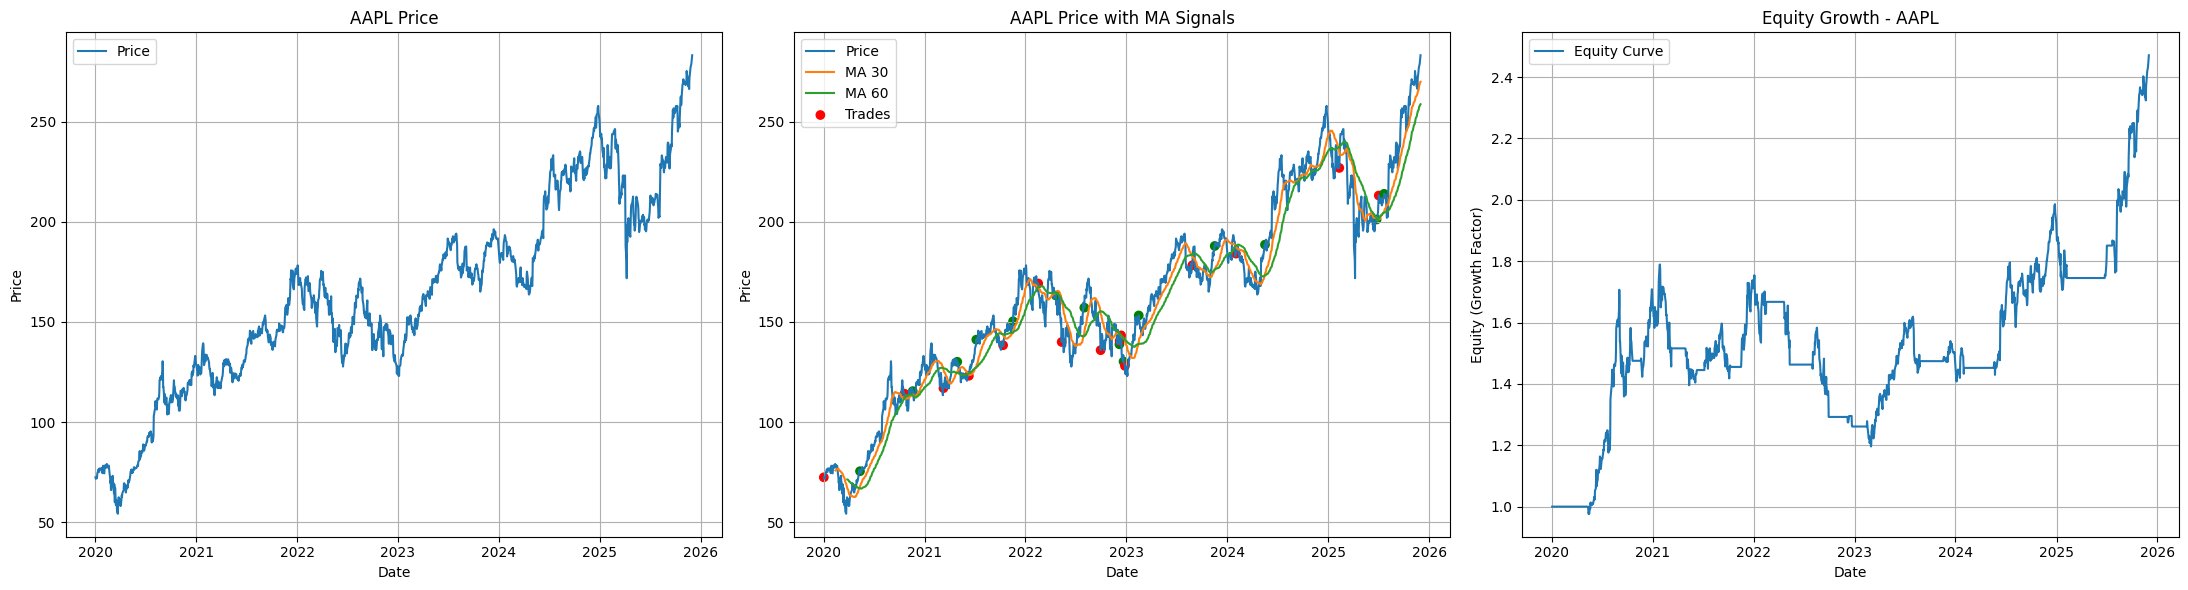

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# strategy
ticker = 'AAPL'
start_date = '2020-01-01'
fast_MA_length = 30
slow_MA_length = 60

# downloads OHLCV and renames Close -> price
df = yf.download(ticker, start=start_date, progress=False)
df = df[['Close']].rename(columns={'Close': 'price'})
df.dropna(inplace=True)

# finds MAs and produces signal
df['MA_fast'] = df['price'].rolling(fast_MA_length).mean()
df['MA_slow'] = df['price'].rolling(slow_MA_length).mean()
df['signal'] = np.where(df['MA_fast'] > df['MA_slow'], 1, 0)

# produces equity curve
df['position'] = df['signal'].shift(1).fillna(0)
df['returns'] = df['price'].pct_change().fillna(0)
df['strategy_returns'] = df['position'] * df['returns']
df['equity_curve'] = (1 + df['strategy_returns']).cumprod()

def sharpe(returns, periods=252):
    if returns.std() == 0:
        return 0
    return (returns.mean() * periods) / (returns.std() * np.sqrt(periods))

def max_drawdown(equity):
    roll_max = equity.cummax()
    dd = (equity - roll_max) / roll_max
    return dd.min()

sharpe_ratio = sharpe(df['strategy_returns'])
mdd = max_drawdown(df['equity_curve'])
cagr = df['equity_curve'].iloc[-1] ** (252/len(df)) - 1

df['trade_change'] = df['position'].diff()
trades = df[df['trade_change'] != 0][['price', 'position']].copy()
trades['type'] = trades['position'].map({1: 'BUY', 0: 'SELL'})

print('---------------------------------------------')
print(f' STRATEGY REPORT: {ticker}')
print('---------------------------------------------')
print(f'Strategy-> fastMA = {fast_MA_length}, slowMA = {slow_MA_length}')
print(f'Start Date-> {start_date}')
print('---------------------------------------------')
print(f'Sharpe Ratio:       {sharpe_ratio:.3f}')
print(f'Max Drawdown:       {mdd:.2%}')
print(f'CAGR:               {cagr:.2%}')
print(f'Final Equity:       {df['equity_curve'].iloc[-1]:.2f}x')
print('---------------------------------------------')
print('\nTRADE LOG:')
print(trades)

with open('strategies.txt', 'a') as f:
    f.write(f'>-{ticker}_{start_date}_fast{fast_MA_length}slow{slow_MA_length}------------\n')
    f.write(' ---------------------------------------------\n')
    f.write(f'  STRATEGY REPORT: {ticker}\n')
    f.write(' ---------------------------------------------\n')
    f.write(f'  Strategy-> fastMA = {fast_MA_length}, slowMA = {slow_MA_length}\n')
    f.write(f'  Start Date-> {start_date}\n')
    f.write(' ---------------------------------------------\n')
    f.write(f'  Sharpe Ratio:       {sharpe_ratio:.3f}\n')
    f.write(f'  Max Drawdown:       {mdd:.2%}\n')
    f.write(f'  CAGR:               {cagr:.2%}\n')
    f.write(f'  Final Equity:       {df['equity_curve'].iloc[-1]:.2f}x\n')
    f.write(' ---------------------------------------------\n\n')

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# axes[0] is the ticker price / time
axes[0].plot(df['price'], label='Price')
axes[0].set_title(f'{ticker} Price')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].grid(True)
axes[0].legend()

# axes[1] is the ticker price / time with MAs and trades
axes[1].plot(df['price'], label='Price')
axes[1].plot(df['MA_fast'], label=f'MA {fast_MA_length}')
axes[1].plot(df['MA_slow'], label=f'MA {slow_MA_length}')
axes[1].scatter(
    trades.index,
    df.loc[trades.index, 'price'],
    c=np.where(trades['type']=='BUY', 'green', 'red'),
    label='Trades'
)
axes[1].set_title(f'{ticker} Price with MA Signals')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].grid(True)
axes[1].legend()

# axes[2] is the equity growth
axes[2].plot(df['equity_curve'], label='Equity Curve')
axes[2].set_title(f'Equity Growth - {ticker}')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Equity (Growth Factor)')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()